# Project 3 - Disease Detection_COVID19

## Introduction:

In this project, the Operations department is part of a hospital that is taking a deep learning approach to look for patterns and methods to speed up the process of testing and diagnostics. As everyone should be familiar by now, in the begining of the year 2020, there was the Coronavirus (Covid-19) outbreak and in this project, the goal is to tackle the challenge of developing an automated system that is able process, detect and classify these chest diseases. The drive here is to save on costs and time for detecting these chest diseases. It is the hope that the model is able to classify these diseases accurately (as well as possible) in less than 1 minute. This dataset consists of X-ray(PA-CXR) images of COVID-19, bacterial and viral pneumonia patients and normal people, where more information can be found in the "Dataset" section below. 

##### Below shows an example of a Chest CT images of a 29-year-old man with fever for 6 days:

<img src="Description Images/Coronavirus_COVID_19_CT_Scans_from_China_pub_in_Radiology.png" width="450">

Image Ref -> https://www.itnonline.com/content/ct-provides-best-diagnosis-novel-coronavirus-covid-19

It would take experience Medical Professionals several minutes or more to confirm or at least partially confirm the results of such a scan. The limiting operational factor here is that this has to be done on a case by case basis, essentially forming a bottleneck in the overall diagnosis process. It is the hope of a Data Scientist to build a model that can speed this part of the process up so that the conclusion can be reach at a faster rate. 

## Breakdown of this Project:
1. Loading in the Dataset.
2. Exploratory Data Analysis (Visualise the data).
3. Examining the Outliers.
4. Dataset preparation (Data cleaning, training and testing splits)
5. Building the CNN Model  (ResNet)
6. Training the Model.
7. Evaluating the Model.
8. Prediction implementation.


## Dataset:

Link: https://www.kaggle.com/unaissait/curated-chest-xray-image-dataset-for-covid19

As quoted from the link, the description is:

This is a combined curated dataset of COVID-19 Chest X-ray images obtained by collating 15 publically available datasets as listed under the references section. The present dataset 
contains:
- 1281 COVID-19 X-Rays.
- 3270 Normal X-Rays.
- 1656 viral-pneumonia X-Rays.
- 3001 bacterial-pneumonia X-Rays.

## Requirements:
- Numpy
- Pandas
- Seaborn
- Matplotlib
- scikit-learn (sklearn)
- os
- timeit
- OpenCV2  (cv2)
- glob
- tensorflow (or Keras)

## 1 - Setting up the Libraries:

In [1]:
# Import the required Library:
import os
import cv2
import glob
import timeit
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

# Run on GPU:
os.environ["CUDA_VISIBLE_DEVICES"]= "0" 


## 2 - Load in the Dataset:

#### Define the Global Dataset Parameters:

In [2]:
# Define the Hyperparameters:
input_shape = [224, 224, 3]
batch_size = 64
nb_epochs = 300

#### Set up the Directory to the Dataset:

In [3]:
# Dataset Filename:
dataset_fileName = 'Curated X-Ray Dataset'

# Set up the Working Directory:
currentDirectory = os.getcwd()
path_to_dataset = currentDirectory + '/Dataset/' + dataset_fileName

In [4]:
# List out the Sub-Folders in the Dataset folder: These are the Classes of images.
os.listdir(path_to_dataset)

['COVID-19', 'Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral']

#### Things to consider before loading in the dataset:
1. Define the batch size, is the number of images in each batch to train on.
2. Shuffling the image data randomly.
3. Resize the image resolution/data, e.g. (224 x 224 x 3) according to ResNet-50 authors)

Luckily, Tensorflow.Keras API has a very useful module called "ImageDataGenerator" that is able to simplify these steps without explicitly define specfic python functions to perform thhe following:
- extracting and loading the images.
- a defined parsing function.
- a defined augmentation function.
- a shuffling function.
- scaling the images.

Link: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [5]:
# Import the required library:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
# Instantiate the Module: ImageDataGenerator.
imgGen = ImageDataGenerator(rescale=1. / 255, 
                            validation_split=0.2)

#### For the Training Set of images:

In [7]:
train_generator = imgGen.flow_from_directory(directory=path_to_dataset,
                                             target_size=tuple(input_shape[:-1]), 
                                             class_mode='categorical', 
                                             batch_size=batch_size,
                                             shuffle=True,
                                             subset='training')

Found 7367 images belonging to 4 classes.


#### For the Validation Set of images:

In [8]:
validation_generator = imgGen.flow_from_directory(directory=path_to_dataset,
                                                  target_size=tuple(input_shape[:-1]), 
                                                  class_mode='categorical', 
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  subset='validation')

Found 1841 images belonging to 4 classes.


### 2.1 - Set the "steps_per_epoch" for Training and Validation Set:

This is the number of batches per epoch of the Dataset objects that has to be specified for the Keras method so that it can work properly together. This is done for the training batches ("steps_per_epoch") and validation batches ("validation_steps").

In [9]:
# Import the required library:
import math

In [10]:
train_steps_per_epoch = math.ceil(train_generator.samples / batch_size)

valid_steps_per_epoch = math.ceil(validation_generator.samples / batch_size)

### 2.2 - Inspect the Training and Validation Sets:

Create a sample of training set images and labels to inspect.

In [11]:
train_imgs, train_labels = next(train_generator)

In [12]:
train_imgs.shape, train_labels.shape

((64, 224, 224, 3), (64, 4))

So here, the training images in each batch consists of 64 images, with a resolution of (224 x 224) and have 3 colour channels (RGB). Interestingly, the labels have 64 label samples but has 4 column/values in it.

Let's have a look at the labels to see why, taking 5 sample of the labels:

In [13]:
train_labels[0:5]

array([[0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

So these should correspond to the 4 labels of this dataset: \
['COVID-19', 'Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral']

Next, is to translate these so that it is understandable later on during the training and prediction stages of this project.

In [14]:
# Define a label dictionary:
label_names_mapping = {0: os.listdir(path_to_dataset)[0], 
                       1: os.listdir(path_to_dataset)[1], 
                       2: os.listdir(path_to_dataset)[2], 
                       3: os.listdir(path_to_dataset)[3]}

# Inspect:
label_names_mapping

{0: 'COVID-19', 1: 'Normal', 2: 'Pneumonia-Bacterial', 3: 'Pneumonia-Viral'}

Great, now that the dataset is set up, on to the next section.

## 3 - Exploratory Data Analysis (EDA):

Here in this section, some visualisations will be performed on the dataset to get a feel of the data.

### 3.1 - Dataset Sample Counts:

Let's have a look at the number of samples in each of the classes/labels.


In [15]:
# Count all of the images for each class:
count_class_0 = 0
count_class_1 = 0
count_class_2 = 0
count_class_3 = 0

dataset_train_val = [train_generator, validation_generator]

for data_type_set in dataset_train_val:
    for i in data_type_set.labels:
        if i == 0:
            count_class_0 += 1
        elif i == 1:
            count_class_1 += 1
        elif i == 2:
            count_class_2 += 1
        else:
            count_class_3 += 1

In [16]:
# Define the Counts and Labels Numpy Arrays:
counts_images = np.array(object=[count_class_0, count_class_1, 
                                 count_class_2, count_class_3])

label_images =  np.array(object=['COVID-19', 'Normal', 
                                 'Pneumonia-Bacterial', 'Pneumonia-Viral'])

# Create a DataFrame to hold the values:
image_df_plotting = pd.DataFrame({'counts':counts_images, 'labels':label_images})

# Inspect the DataFrame:
image_df_plotting

,counts,labels
0,1281,COVID-19
1,3270,Normal
2,3001,Pneumonia-Bacterial
3,1656,Pneumonia-Viral


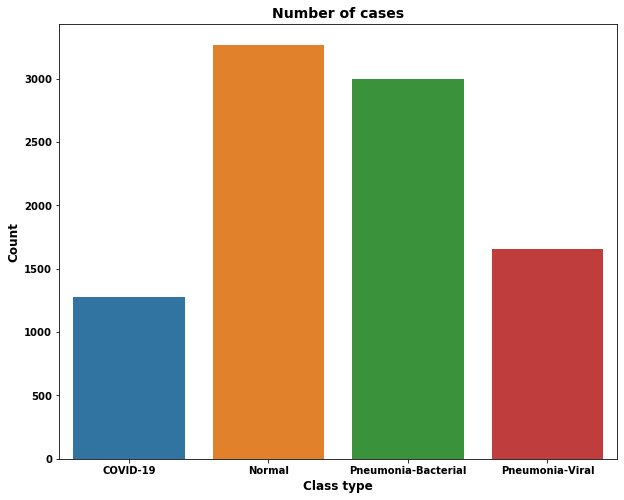

In [17]:
# Plot:
plt.figure(figsize=(10,8))
sns.barplot(x=image_df_plotting.labels, y=image_df_plotting.counts, palette='tab10')
plt.title('Number of cases', fontsize=14)
plt.xlabel('Class type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()


### 3.2 - Visualise the Dataset according to each class:

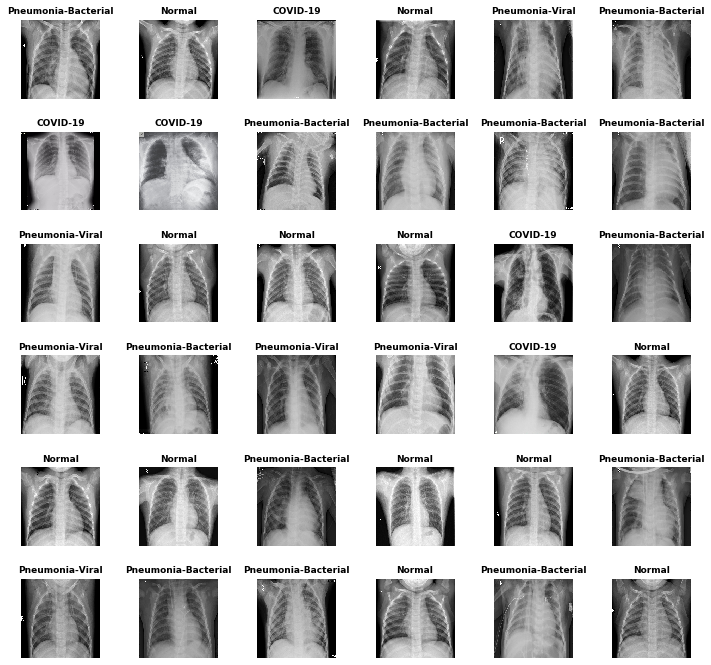

In [18]:
# Define the Grid Size:
grid_size = [6, 6]
grid_area = grid_size[0] * grid_size[1]

# Create a visualisation grid to plot:
fig, ax = plt.subplots(grid_size[0], grid_size[1], figsize=(12, 12))
ax = ax.ravel()

for i in np.arange(0, grid_area):
    ax[i].imshow(train_imgs[i])
    ax[i].set_title(label_names_mapping[ np.argmax(train_labels[i]) ], fontsize=9)
    ax[i].axis('off')
    
    
plt.subplots_adjust(wspace=0.5)


## 4 - Build the ResNet Model:

### 4.1 - Background on ResNet:

The ResNet Architecture is a network that takes on a more efficient apporach in creating very deep networks with the "Residual Module". This model was developed by Microsoft. 

One of the challenges with deep networks is the vanishing or exploding gradient problem, where the training process becomes harder as the number of layers increases. Another challenge is that deeper networks also have a degrading performance hit. This is where the accuracy of the network no longer linearly increases with the addition of new layers to its architecture. The training loss can also be seen to decrease, provided that there is no overfitting.

ResNet won the ILSVRC of 2015 employing techniques such as model averaging and prediction averaging, which aided the model to achieve a historically low 3.6% top-5 error rate. It was also the first time the model was able to beat humans on the given dataset.

Similar to the Inception Network, the ResNet model have gone through several iterative architectural improvements. For example, the model added bottleneck convolutions and smaller kernels. ResNet also have several versions that coincides with the number of layers, such as ResNet-18, ResNet-50, ResNet-101, ResNet-152 and so on.

##### Below is a diagram that shows the building blocks of the ResNet Model:

<img src="Description Images/ResNet1.PNG" width="750">

Image Ref -> https://towardsdatascience.com/architecture-comparison-of-alexnet-vggnet-resnet-inception-densenet-beb8b116866d and https://www.researchgate.net/figure/Residual-block-top-left-bottleneck-layer-bottom-left-and-ResNet-architectures_fig4_334455007

From the diagram above, the architecture follows with all the convolutional operations and max-pooling layers having padding that is "SAME" with a stride = 1. Batch normalisation is then applied to both the following, after each of the 3x3 convolutions as seen by the residual path (GREEN) and the 1x1 convolutions with no activation function as seen by the mapping path (BLUE).

ResNet blocks are composed of one non-linear path (residual path) and an identity path (mapping path). From the diagram above, the residual block on the residual path applies two convolutions with batch normalisation then followed by ReLU activation on the input feature maps. It also have an identity path which only forwards the features without applying any transformations.

It is also notable that sometimes, when the depth is increased in parallel by non-linear branches, a 1x1 convolutions are applied to the network on the Mapping path after a couple of residual blocks to help the model adapt to the depth of the features. This avoids the increase in the number of parameters. Further, the spatial dimensionality can also be reduced by using stride = 2 on both side.

The feature maps from each of the branch are merged together before moving onto the following residual block. The operation here is not a depth-wise concatenation but it is done through element-wise addition. This also means that there is no increase in parameters which is an added advantage of the model. As it can be in the diagram, it uses a non-linear function (  𝐹(𝑥)+𝑥  ) to merge. Lastly, the output features of the last block are tthen average-pooled and densely converted into predictions.

The entire ResNet model of varying depth of layers is composed of these residual blocks stacked on each other.

### 4.2 - ResNet Implementation with Keras API:

In [19]:
# Import the required Libraries:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Activation, Dense, Dropout, 
                                     Flatten, Conv2D, MaxPooling2D, 
                                     GlobalAveragePooling2D, AveragePooling2D, 
                                     BatchNormalization, add)
import tensorflow.keras.regularizers as regulisers

### 4.3 - Implement the Individual Components of the Residual Blocks:

For the purpose of building a ResNet model builder function that is capable of generating a network of different sizes, the implementation of ResNet therefore have to be modular as well. To do this, each of the components that make up the ResNet model will implemented separately/modular below.

__Residual Blocks__ are composed of the following:
- 1x Residual Branch; a 3x3 convolution on the input data, followed by batch normalisation and then a ReLU activation function.
- 1x Shortcut Branch; it directly forwards the input without any modification, or that it can apply a 1x1 convolution to adapt the input volume where in the case it changes in the other branch.
- 1x Merge Operation; consisting of an element-wise addition between the output results of the two branches.


#### 4.3.1 - (Subblock 1) Residual Branch:

Wrap the convolution, batch normalisation and ReLU activation as a stack of layers into a single function. The function below allows for the addition of 3 stacked layers (conv_bn_Relu) with just a " x = _conv_bn_Relu(**params)(x) " code for the residual branch.

This is also called the __residual path (GREEN)__.

<img src="Description Images/ResNet_ResidualBlock.PNG" width="250">

Image Ref -> https://towardsdatascience.com/architecture-comparison-of-alexnet-vggnet-resnet-inception-densenet-beb8b116866d

In [20]:
def _res_conv(filters, kernel_size=3, padding='same', strides=1, use_relu=True, use_bias=False, name='conv_bn_Relu', 
              kernel_initialiser = 'he_normal', kernel_regulariser = regulisers.l2(1e-5)):
    """ This builds the Residual Branch, consisting of the Convolutions, batch norm and ReLU activation.
    Parameters:
        - filters, is the number of filters.
        - kernel_size, is the Kernel Size.
        - padding, is the convolution padding.
        - strides, is the convolution stride.
        - use_rele, is a Flag to apply the ReLU activation function at the end.
        - use_bias, is a Flag to use or not the bias in the Convolutional layer.
        - name, is the Name Suffix for the layers.
        - kernel_initialiser, is the Kernel initialisattion method name.
        - kernel_regulariser, is the kernel regulariser.
    Returns:
        - returns a Callable Layer Block.
    """
    def layer_func(x):
        # Convolution:
        conv = Conv2D(filters=filters,
                      kernel_size=kernel_size,
                      strides=strides,
                      padding=padding,
                      use_bias=use_bias,
                      kernel_initializer=kernel_initialiser,
                      kernel_regularizer=kernel_regulariser,
                      name=name + '_c'
                     )(x)
                
        # Batch Norm:
        residual_branch = BatchNormalization(axis=-1,
                                             name=name + '_bn'
                                            )(conv)
        
        # ReLU activation:
        if use_relu:
            residual_branch = Activation(activation='relu',
                                         name=name + '_r'
                                        )(residual_branch)
        return residual_branch
    
    return layer_func

#### 4.3.2 - (Subblock 2) Residual Shortcut Branch:

Simplifying the __shortcut operation__ can be done by coupling it with the __merge operation__. This "_merge_with_shortcut" function needs to receive parameters of both the input tensor and the results of the residual branch, so that it can compare the shapes of the tensor, checking that the dimensions were changed or not. 

If the dimensions were changed, a 1x1 convolution will be applied to resize the input tensor before merging. If unchanged, the input tensor will be left unaltered. 

As this function have both the residual and shortcut results, it can merge the results together.

This is also called the __mapping path (BLUE)__.

<img src="Description Images/ResNet_ResidualBlock.PNG" width="250">

Image Ref -> https://towardsdatascience.com/architecture-comparison-of-alexnet-vggnet-resnet-inception-densenet-beb8b116866d

In [21]:
# A.K.A the Identity Block.
def _merge_with_shortcut(kernel_initialiser = 'he_normal', kernel_regulariser = regulisers.l2(1e-5), name='block'):
    """ This builds the merging layer block for the input tensor and the residual branch output tensor.
    Parameters:
        - kernel_initialiser, is the Kernel initialisation method name.
        - kernel_regulariser, is the Kernel regulariser.
        - name, is the Name Suffix of this layer.
    Returns:
        - returns a Callable Layer Block.
    """
    def layer_func(x, x_residual):
        # Check if there are changes made to the residual branch output "x_residual": 
        # if changed, apply 1x1 convolutions.
        x_shape=tf.keras.backend.int_shape(x)
        x_residual_shape=tf.keras.backend.int_shape(x_residual)
        
        if (x_shape == x_residual_shape):
            shortcut=x
        else:
            strides = (
                        int(round(x_shape[1] / x_residual_shape[1])), # Vertical Stride.
                        int(round(x_shape[2] / x_residual_shape[2]))  # horizontal Stride.
                      )
            x_residual_chnls=x_residual_shape[3]
            
            shortcut=Conv2D(filters = x_residual_chnls,
                            kernel_size = (1, 1),
                            strides = strides,
                            padding = "valid",
                            kernel_initializer = kernel_initialiser,
                            kernel_regularizer = kernel_regulariser,
                            name = name + '_shortcut_c'
                           )(x)
            
        # Merge the shortcut and residual:
        merge = add( [shortcut, x_residual] )

        # Return the merged output:
        return merge
        
    return layer_func

### 4.3.3 - Complete Residual Block:

The complete residual block will be formed by chaining the residual blocks:
- _residual_block_basic(filters=64, strides=2)(x)
- _residual_block_basic(filters=64, strides=1)(x)
- where (x) is the previous layer.

<img src="Description Images/ResNet_ResidualBlock2.PNG" width="250">

Image Ref -> https://towardsdatascience.com/architecture-comparison-of-alexnet-vggnet-resnet-inception-densenet-beb8b116866d

In [22]:
def _residual_block_basic(filters, kernel_size=3, strides=1, use_bias=False, kernel_initialiser='he_normal', 
                          kernel_regulariser=regulisers.l2(1e-5), name='res_basic'):
    """ This builds the Basic Residual Layer Block.
    Parameters:
        - filters, is the number of filters.
        - kernel_size, is the kernel size.
        - strides, is the convolutional strides.
        - use_bias, is a Flag to use or not the bias in the convolution layer.
        - kernel_initialiser, is the kernel initialisation method name.
        - kernel_regulariser, is the kernel regulariser.
    Returns:
        - returns a Callable Layer Block.
    """
    def layer_func(x):
        # For the Residual Branch - the First Convolution block:
        x_conv1 = _res_conv(filters=filters,
                            kernel_size=kernel_size,
                            padding='same',
                            strides=strides,
                            use_relu=True,
                            use_bias=use_bias,
                            kernel_initialiser=kernel_initialiser,
                            kernel_regulariser=kernel_regulariser,
                            name=name + '_conv_bn_Relu1'
                           )(x)
        
        # For the Residual Branch - the Second Convolution block:
        x_residual = _res_conv(filters=filters,
                            kernel_size=kernel_size,
                            padding='same',
                            strides=1,
                            use_relu=False,
                            use_bias=use_bias,
                            kernel_initialiser=kernel_initialiser,
                            kernel_regulariser=kernel_regulariser,
                            name=name + '_conv_bn_Relu2'
                           )(x_conv1)
        
        # For the Merging (Identity/shortcut) Branch:
        merge = _merge_with_shortcut(kernel_initialiser=kernel_initialiser,
                                     kernel_regulariser=kernel_regulariser,
                                     name=name)(x, x_residual)
        
        merge = Activation('relu')(merge)
        
        # Return the merged output:
        return merge
    
    return layer_func
    

### 4.3.4 - Complete Bottleneck Residual Block:

Before estanblishing the final complete model, there is a secondary residual block (Bottleneck block) that requires implementation. Geoffrey Hinton suggests a bottleneck residual block that combats the computationally complex basic residual blocks when the network becomes deeper. This is where the two 3x3 convolutions are replaced by one 3x3 convolutions that is surrounded by 1x1 ones.

<img src="Description Images/ResNet_BottleneckBlock.PNG" width="250">

Image Ref -> https://www.researchgate.net/figure/Residual-block-top-left-bottleneck-layer-bottom-left-and-ResNet-architectures_fig4_334455007


In [23]:
def _residual_bottleneck_blocks(filters, kernel_size=3, strides=1, use_bias=False, 
                                kernel_initialiser='he_normal', kernel_regulariser=regulisers.l2(1e-5), name='res_bottleneck'):
    """ This builds the Bottlenecked Residual Blocks, for a ResNet model deeper than 34 layers.
    Parameters:
        - filters, is the number of filters.
        - kernel_size, is the kernel size.
        - strides, is the convolutional strides.
        - use_bias, is a Flag to use or not the bias in the convolution layer.
        - kernel_initialiser, is the kernel initialisation method name.
        - kernel_regulariser, is the kernel regulariser.
    Returns:
        - returns a Callable Layer Block.
    """
    def layer_func(x):
        # For the Bottleneck Residual Branch - the First (bottlenecked) Convolution block:
        x_bottleneck = _res_conv(filters=filters, 
                                 kernel_size= 1, 
                                 padding='valid', 
                                 strides=strides, 
                                 use_relu=True, 
                                 use_bias=use_bias, 
                                 kernel_initialiser=kernel_initialiser, 
                                 kernel_regulariser=kernel_regulariser, 
                                 name=name + '_conv_bn_Relu1'
                                )(x)
        
        # For the Residual Branch - the first (non-bottlenecked) Convolution block:
        x_conv = _res_conv(filters=filters, 
                           kernel_size=kernel_size, 
                           padding='same', 
                           strides=1, 
                           use_relu=True, 
                           use_bias=use_bias, 
                           kernel_initialiser=kernel_initialiser, 
                           kernel_regulariser=kernel_regulariser, 
                           name=name + '_conv_bn_Relu2'
                          )(x_bottleneck)
        
        # For the Residual Branch - the Second (non-bottlenecked) Convolution block:
        x_residual = _res_conv(filters=filters * 4, 
                               kernel_size= 1, 
                               padding='valid', 
                               strides= 1, 
                               use_relu=False, 
                               use_bias=use_bias, 
                               kernel_initialiser=kernel_initialiser, 
                               kernel_regulariser=kernel_regulariser, 
                               name=name + '_conv_bn_Relu3'
                              )(x_conv)
        
        # For the Merging (Identity/shortcut) Branch:
        merge = _merge_with_shortcut(kernel_initialiser=kernel_initialiser,
                                     kernel_regulariser=kernel_regulariser,
                                     name=name)(x, x_residual)
        
        merge = Activation('relu')(merge)
        
        # Return the merged output:
        return merge
    
    return layer_func
        

### 4.3.5 - Combining by chaining the blocks together forming the Modular Network:

<img src="Description Images/ResNet_b_block.PNG" width="350">

Image Ref -> https://www.researchgate.net/figure/Residual-block-top-left-bottleneck-layer-bottom-left-and-ResNet-architectures_fig4_334455007

In [24]:
def _residual_macroblock(block_func, filters, repetitions =3, kernel_size=3, strides_1stBlock = 1, use_bias=False, 
                                kernel_initialiser='he_normal', kernel_regulariser=regulisers.l2(1e-5), name='res_macroblock'):
    """ This builds the a Layer block that is composed of a repetition of 'N' number of residual blocks.
    Parameters:
        - block_fun, is the Block Layer method.
        - repetitions, is the number of times the block func is repeated inside.
        - filters, is the number of filters.
        - kernel_size, is the kernel size.
        - strides_1st_block, is the convolutional strides for the 1st block.
        - use_bias, is a Flag to use or not the bias in the convolution layer.
        - kernel_initialiser, is the kernel initialisation method name.
        - kernel_regulariser, is the kernel regulariser.
    Returns:
        - returns a Callable Layer Block.
    """
    def layer_func(x):
        
        # Loop through the specified number of repetitions:
        for i in range(repetitions):
            block_name = "{}_{}".format(name, i)
            strides = strides_1stBlock if i == 0 else 1
            x = block_func(filters=filters,
                           kernel_size=kernel_size,
                           strides=strides,
                           use_bias=use_bias,
                           kernel_initialiser=kernel_initialiser,
                           kernel_regulariser=kernel_regulariser,
                           name=block_name)(x)
            
        # Return the output from this loop:
        return x
    
    return layer_func
    

### 4.3.6 - Complete the ResNet Model: includes the intial and final Layers.

Previously, the code blocks were to implement the layers of residual blocks before the final layers. The final layers of the ResNet model here will be composed of the 3 layers preceeding the residual blocks, that is a 7x7 convolution and a max-pooling layer, and also the final fully connected layers that leads to the prediction output.

The following function should call the defiend functions in the previous code blocks to form the final ResNet model (of any size). 

##### Below is a diagram that shows the Input, Repetition and Output Layers:

<img src="Description Images/ResNet_Input_Repeat_Output.png" width="350">

Image Ref -> https://www.researchgate.net/figure/Residual-block-top-left-bottleneck-layer-bottom-left-and-ResNet-architectures_fig4_334455007

The code block below essentially allows for creation of a ResNet model that can be shallow or deep or very deep, with the use of the "repetitions" parameter.

In [25]:
def ResNet(input_shape, nb_classes=1000, block_func=_residual_block_basic, repetitions=(2, 2, 2, 2),
           use_bias=False, use_dropout=False, kernel_initialiser='he_normal', kernel_regulariser=regulisers.l2(1e-5)):
    """ This builds the ResNet Model for the Classification task.
    Parameters:
        - input_shape, is the input data shape such as (224, 224, 3).
        - nb_classes, is the number of classes to be predicted.
        - block_func, is the Block Layer method to be used.
        - repetitions, is the List of repetitions for each macro-blocks the network should build/contain.
        - use_bias, is a Flag to use or not the bias in the convolution layer.
        - use_dropout, is a Flag to use or not the dropout in the Fully-connected layer.
        - kernel_initialiser, is the kernel initialisation method name.
        - kernel_regulariser, is the kernel regulariser.
    Returns:
        - returns the ResNet model.
    """
    # ResNet's Input layer:
    inputs = Input(shape = input_shape)
    
    conv = _res_conv(filters=64,
                    kernel_size=7,
                    strides=2,
                    use_relu=True,
                    use_bias=use_bias,
                    kernel_initialiser=kernel_initialiser,
                    kernel_regulariser=kernel_regulariser
                    )(inputs)
    
    maxpool = MaxPooling2D(pool_size=3, 
                           strides=2, 
                           padding='same')(conv)
    
    # Resnet's chain of Residual Blocks (Repetition Layers):
    filters = 64
    strides = 2
    res_block = maxpool
    
    for i, repet in enumerate(repetitions):
        # NOTE: no further input size reduction for the 1st block, as max-pooling was applied prior.
        block_strides = strides if i != 0 else 1
        macroblock_name = "block_{}".format(i)
        
        res_block = _residual_macroblock(block_func=block_func,
                                               filters=filters,
                                               repetitions=repet,
                                               strides_1stBlock=block_strides,
                                               use_bias=use_bias,
                                               kernel_initialiser=kernel_initialiser,
                                               kernel_regulariser=kernel_regulariser,
                                               name=macroblock_name
                                              )(res_block)
        
        # Limit the number of filters to 1024 as the maximum:
        filters = min(filters * 2, 1024)   
    
    # Resnet's Final/Output Layer:
    res_spatial_dimen = tf.keras.backend.int_shape(res_block)[1:3]
    
    avg_pool = AveragePooling2D(pool_size=res_spatial_dimen,
                                strides=1
                               )(res_block)
    
    flatten = Flatten()(avg_pool)
    
    # Adding a fully connected layer having 1024 neurons
    FC_layer = Dense(units=1024, 
                     activation='relu', 
                     use_bias=True, 
                     kernel_initializer='glorot_uniform')(flatten)
    
    # Adding dropout, if True:
    if use_dropout:
        FC_layer = Dropout(rate=0.5)(FC_layer)
    
    
    predictions = Dense(units=nb_classes,
                        activation='softmax',
                        kernel_initializer=kernel_initialiser
                       )(FC_layer)
    
    # Model (Keras API):
    model = Model(inputs=inputs, 
                  outputs=predictions)
    
    # Return the model configurations:
    return model


## 5 - Define the ResNet Models: ResNet-18 all the way to ResNet-152

Here, it is possible to instantiate all of the classic ResNet models that were originally developed.

In [26]:
def ResNet18(input_shape, nb_classes = 1000, use_bias = True, use_dropout = True,
             kernel_initialiser = 'he_normal', kernel_regulariser = None):
    return ResNet(input_shape,
                  nb_classes= nb_classes,
                  block_func= _residual_block_basic,
                  repetitions = (2, 2, 2, 2),
                  use_bias = use_bias,
                  use_dropout = use_dropout,
                  kernel_initialiser = kernel_initialiser,
                  kernel_regulariser = kernel_regulariser)

def ResNet34(input_shape, nb_classes = 1000, use_bias = True, use_dropout = True,
             kernel_initialiser = 'he_normal', kernel_regulariser = None):
    return ResNet(input_shape,
                  nb_classes= nb_classes,
                  block_func= _residual_block_basic,
                  repetitions = (3, 4, 6, 3),
                  use_bias = use_bias,
                  use_dropout = use_dropout,
                  kernel_initialiser = kernel_initialiser,
                  kernel_regulariser = kernel_regulariser)


# For ResNet50, the basic residual blocks are replaced with bottleneck residual blocks instead:
def ResNet50(input_shape, nb_classes = 1000, use_bias = True, use_dropout = True,
             kernel_initialiser = 'he_normal', kernel_regulariser = None):
    return ResNet(input_shape,
                  nb_classes= nb_classes,
                  block_func= _residual_bottleneck_blocks,
                  repetitions = (3, 4, 6, 3),
                  use_bias = use_bias,
                  use_dropout = use_dropout,
                  kernel_initialiser = kernel_initialiser,
                  kernel_regulariser = kernel_regulariser)

def ResNet101(input_shape, nb_classes = 1000, use_bias = True, use_dropout = True,
              kernel_initialiser = 'he_normal', kernel_regulariser = None):
    return ResNet(input_shape,
                  nb_classes= nb_classes,
                  block_func= _residual_bottleneck_blocks,
                  repetitions = (3, 4, 23, 3),
                  use_bias = use_bias,
                  use_dropout = use_dropout,
                  kernel_initialiser = kernel_initialiser,
                  kernel_regulariser = kernel_regulariser)

def ResNet152(input_shape, nb_classes = 1000, use_bias = True, use_dropout = True,
              kernel_initialiser = 'he_normal', kernel_regulariser = None):
    return ResNet(input_shape,
                  nb_classes= nb_classes,
                  block_func= _residual_bottleneck_blocks,
                  repetitions = (3, 4, 36, 3),
                  use_bias = use_bias,
                  use_dropout = use_dropout,
                  kernel_initialiser = kernel_initialiser,
                  kernel_regulariser = kernel_regulariser)

## 6 - Train the ResNet Model for this Task:

Here the Current Model utilised will be: __ResNet-50__ model

#### Instantiate the model:

In [27]:
# Define the number of Classes:
nb_classes = len(np.unique(train_generator.labels))

# Instantiate the model:
resnet50 = ResNet50(input_shape=input_shape,
                    nb_classes=nb_classes)

# Model Summary:
resnet50.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv_bn_Relu_c (Conv2D)         (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
conv_bn_Relu_bn (BatchNormaliza (None, 112, 112, 64) 256         conv_bn_Relu_c[0][0]             
__________________________________________________________________________________________________
conv_bn_Relu_r (Activation)     (None, 112, 112, 64) 0           conv_bn_Relu_bn[0][0]            
______________________________________________________________________________________________

### 6.1 - Preparation for Training:

Instantiate the model optimiser and the required callbacks for visualisation of the model performance. This also saves the model's progress and results.

In [28]:
import collections

In [29]:
# Setting some variables to format the logs:
log_begin_red, log_begin_blue, log_begin_green = '\033[91m', '\033[94m', '\033[92m'
log_begin_bold, log_begin_underline = '\033[1m', '\033[4m'
log_end_format = '\033[0m'

In [30]:
class Simplified_LogCallback(tf.keras.callbacks.Callback):
    """ This builds the Keras Callbacks for a more simpler and concise console logs."""
    def __init__(self, metrics_dict, nb_epochs='?', log_frequency=1, 
                 metric_string_template='\033[1m[[name]]\033[0m = \033[94m{[[value]]:5.3f}\033[0m'):
        """ This is the Initialisation of the Callback.
        Parameters:
            - metrics_dict, is the Dict containing the mappings for metrics names(or keys), 
                    e.g. {"accuracy": "acc", "val. accuracy": "val_acc"}.
            - nb_epochs, is the number of training epochs.
            - log_frequency, is the frequency that the logs will be printed in epochs.
            - metric_string_template, is an optional Sttring template to print each of the metric.
        """
        # Initialise and Inherit "tf.keras.callbacks.Callback":
        super().__init__()
        
        self.metrics_dict = collections.OrderedDict(metrics_dict)
        self.nb_epochs = nb_epochs
        self.log_frequency = log_frequency
        
        # Build the format for printing out the metrics:
        # e.g. "Epoch 0/9: loss = 1.00; val-loss = 2.00"
        log_string_template = 'Epoch {0:2}/{1}: '
        separator = '; '
        
        i = 2
        for metric_name in self.metrics_dict:
            templ = metric_string_template.replace('[[name]]', metric_name).replace('[[value]]', str(i))
            log_string_template += templ + separator
            i += 1
            
        # Remove the "; " (separator) after the last element:
        log_string_template = log_string_template[:-len(separator)]
        self.log_string_template = log_string_template
        
    def on_train_begin(self, logs=None):
        print("Training: {}start{}".format(log_begin_red, log_end_format))
        
    def on_train_end(self, logs=None):
        print("Training: {}end{}".format(log_begin_green, log_end_format))
        
    def on_epoch_end(self, epoch, logs= {}):
        if (epoch - 1) % self.log_frequency == 0 or epoch == self.nb_epochs:
            values = [logs[self.metrics_dict[metric_name]] for metric_name in self.metrics_dict]
            print(self.log_string_template.format(epoch, self.nb_epochs, *values))
            

#### Callbacks:

This section will implement a custom Callback Class. It defines an interface that is composed of several methods, that will be called by Keras during the training process. The intervals for calling Keras are "before each epoch", "before each batch iteration", "after each batch iteration" and so on.

NOTE: to ensure that the logs are concise, a "log_frequency" variable will be used to print out the results at different intervals during the training process.


In [31]:
# Set up Path Directory to Save the Model:
model_name = 'ResNet50_Covid19'
model_dir = os.path.join('.', 'models', model_name)

# Set up the Metrics to Print:
metrics_to_print = collections.OrderedDict( [("loss", "loss"), 
                                            ("v-loss", "val_loss"),
                                            ("acc", "acc"), 
                                            ("v-acc", "val_acc")] 
                                          )

callbacks = [
    
    # Callback to interrupt the training if the validation loss/metric stops imrpoving for some amount of epochs:
    tf.keras.callbacks.EarlyStopping(monitor='loss',
                                     patience=8,
                                     restore_best_weights=True
                                    ),
    
    # Callback to log the graph, Losses and Metrics into TensorBoard:
    tf.keras.callbacks.TensorBoard(log_dir = model_dir,
                                    histogram_freq = 0,
                                    write_graph = True
                                  ),
    
    # Callback to save the model specifying the epoch and val-loss in the filename:
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(model_dir, 'weights-epoch{epoch:02}-loss{val_loss:.2f}.h5'), period=5),
    
    # Log the Callbacks:
    Simplified_LogCallback(metrics_dict = metrics_to_print, 
                                             nb_epochs = nb_epochs, 
                                             log_frequency= 2)

    ]


#### Load Saved Weights:

Create a folder called "models" in directory.

In [32]:
# Check if "models" folder hhas been created or not: create it if not found.
models_directory = os.path.join(currentDirectory, r'models')
if not os.path.exists(models_directory):
    os.makedirs(models_directory)

# Load Previous Model Weights (when kernel crashes):
found_folder = None
for weight_folder in os.listdir('.\\models\\'):
    if(model_dir.split('.\\models\\')[1] == weight_folder):
        found_folder = str(weight_folder)
        
if(model_dir.split('.\\models\\')[1] == found_folder):
    # Set the model to load for:
    model = resnet50 # <========================== Set History Object here.

    All_saved_weightFiles = []
    for filename in os.listdir(model_dir):
        if 'weights-epoch' in filename:
            All_saved_weightFiles.append(filename)
            weights_file_name = All_saved_weightFiles[-1]
            model.load_weights(model_dir + '/' + weights_file_name)
    
    if not All_saved_weightFiles:
        print('Folder found, but Weights file was not found, Proceeding to creating a new one.')
        pass
    else:
        print("Model's weigth folder was found, proceeding to using previous Saved Weights.")
        print("Saved Weights Filename -> {}".format(weights_file_name))
        
else:
    print("Model's weight folder was not found inside '.\models\' folder. Proceeding to creating a new one.'")
    pass 

Model's weight folder was not found inside '.\models' folder. Proceeding to creating a new one.'


### 6.2 - Training the Model: ResNet-50

#### Compile the model:

In [33]:
# Define the model optimiser:
optimiser = tf.keras.optimizers.Adam()

# Define the accuracy metric:
accuracy_metric = tf.metrics.CategoricalAccuracy(name='acc')


In [34]:
resnet50.compile(optimizer = optimiser,
                 loss = 'categorical_crossentropy',
                 metrics = [accuracy_metric]
                )

#### Train the Model:

In [35]:
# running time calculation
start = timeit.default_timer()

history_resnet50_model = resnet50.fit(train_generator,
                                      epochs=nb_epochs,
                                      steps_per_epoch=train_steps_per_epoch,
                                      validation_data=validation_generator,
                                      validation_steps=valid_steps_per_epoch,
                                      verbose=0,
                                      callbacks=callbacks)

# Stop the timer:
stop = timeit.default_timer()
print('Time: {} Minutes'.format(round((stop - start)/60, 2)))
print('Time: {} hours'.format(round((stop - start)/3600, 2)))

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training: start
Epoch  1/300: loss = 0.552; v-loss = 1.783; acc = 0.772; v-acc = 0.309
Epoch  3/300: loss = 0.451; v-loss = 1.812; acc = 0.812; v-acc = 0.627
Epoch  5/300: loss = 0.405; v-loss = 5.934; acc = 0.832; v-acc = 0.427
Epoch  7/300: loss = 0.350; v-loss = 1.743; acc = 0.851; v-acc = 0.557
Epoch  9/300: loss = 0.325; v-loss = 3.301; acc = 0.859; v-acc = 0.532
Epoch 11/300: loss = 0.351; v-loss = 0.750; acc = 0.848; v-acc = 0.681
Epoch 13/300: loss = 0.287; v-loss = 0.771; acc = 0.877; v-acc = 0.747
Epoch 15/300: loss = 0.262; v-loss = 1.669; acc = 0.886; v-acc = 0.562
Epoch 17/300: loss = 0.255; v-loss = 1.184; acc = 0.895; v-acc = 0.643
Epoch 19/300: loss = 0.210; v-loss = 4.531; acc = 0.922; v-acc = 0.556
Epoch 21/300: loss = 0.167; v-loss = 2.165; acc = 0.935; v-acc = 0.512
Epoch 23/300: loss = 0.164; v-loss = 0.588; acc = 0.939; v-acc = 0.792
Epoch 25/300: loss = 0.125; v-loss = 2.140; acc = 0.952; v-acc = 0.532
Epoch 27/30

### Observation:


## 7 - Plot the Model's Performance during Training Phase:

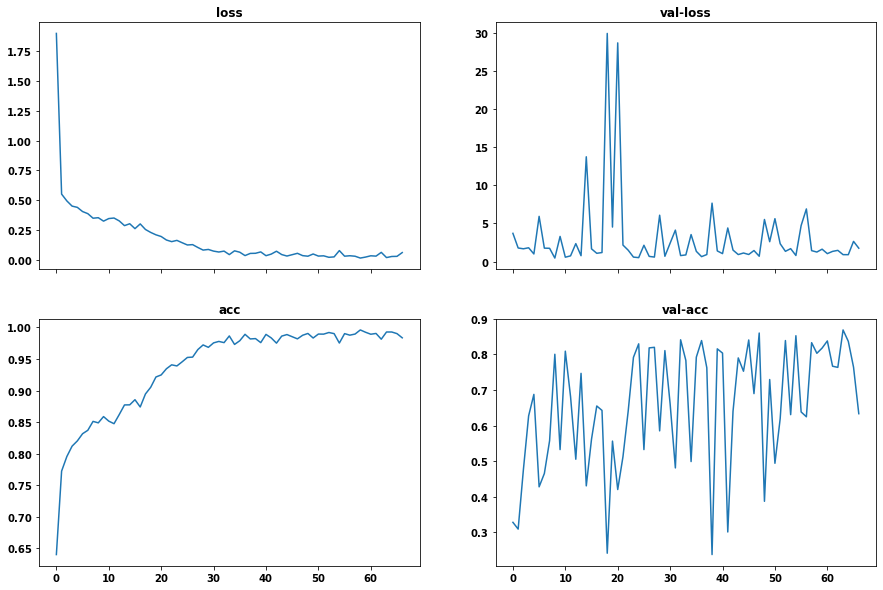

In [36]:
# Define the History Object to plot with:
history = history_resnet50_model

# Plot:
fig, ax = plt.subplots(2, 2, figsize=(15, 10), sharex='col') # add parameter `sharey='row'` for a more direct comparison
ax[0, 0].set_title("loss")
ax[0, 1].set_title("val-loss")
ax[1, 0].set_title("acc")
ax[1, 1].set_title("val-acc")

ax[0, 0].plot(history.history['loss'])
ax[0, 1].plot(history.history['val_loss'])
ax[1, 0].plot(history.history['acc'])
ax[1, 1].plot(history.history['val_acc'])



In [37]:
# Get the best performing scores:
best_val_accuracy = max(history.history['val_acc']) * 100

# Print out the results:
print("Best Validation Accuracy: {:2.2f}%".format(best_val_accuracy))


Best Validation Accuracy: 86.91%


#### Save the Model:

In [38]:
resnet50.save(filepath= 'saved_model/' + 'resnet50_model.hdf5', 
              overwrite=True, 
              include_optimizer=True)

### Observation:

It can be seen that both the Validation Loss and Accuracy are fluctuating heavily, this is bad and the root of the problem can vary. One way to describe on what is happening with the model is that it was __overfitting__ the dataset and produces this behaviour with thhe validation data.

Other possible interpretations of what is happening are:
- There aren't enough data in the validation set.
- The learning rate was too large.
- The ResNet model requires some regularisation (perhaps in the Fully-Connected Layers)
- The ResNet model's Fully-Connected layers may need to be altered to have deeper layers or less nodes.


## 8 - Testing the Model: Model Predictions with Unseen Data.

In [39]:
# Import the required libraries:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [40]:
def load_image(image_path, size):
    """ This builds an Image Loader where it converts the images into Numpy Arrays.
    Parameters:
        - image_path, is the directory pathway to the images.
        - size, is the target size of the images.
    Returns:
        - returns an Image Array, that is normalised between 0 and 1.
    """
    image = img_to_array(load_img(image_path, target_size = size)) / 255.
    return image

def process_predictions(class_probabilities, class_readable_labels, k=4):
    """ This builds a Batch of predictions from the Estimator.
    Parameters:
        - class_probabilities, is the prediction results that is returned by the Keras Classifier for a batch of data.
        - class_readable_labels, is the List of readable class labels that is used for display.
        - k, is the number of top predictions in/for consideration.
    Returns:
        - returns the readable labels and probabilities for the predicted classes.
    """
    # Define an empty array for the Labels and Probabilities:
    topk_labels = []
    topk_probabilities = []
    top5_probabilities = []
    
    # Loop through the (sorted for top 5) predictions:
    for i in range(len(class_probabilities)):
        
        # Grab the top-k predictions: "-k" takes the first 5 results.
        topk_classes = sorted(np.argpartition(class_probabilities[i], -k)[-k:])
        
        # Get the corresponding labels and predictions:
        topk_labels.append( [class_readable_labels[predicted] for predicted in topk_classes] )
        
        # Update the List while,
        # Convert Eager Tensor to Numpy Array: for compatibility of loop iterations.
        class_probabilities = np.array(class_probabilities)
        topk_probabilities.append(class_probabilities[i][topk_classes])

    # Return the labels and its probabilities:
    return topk_labels, topk_probabilities

def display_predicitons(images, topk_labels, topk_probabilities, true_labels=None, set_true_labels=False):
    """ This build a Plotting function to display the batch of predictions.
    Parameters:
        - iamges, is the Batch of input images.
        - topk_labels, is the String labels of the predicted classes.
        - topk_probabilities, is the probabilities for each of the classes.
        - true_labels, is the List of True Labels for the testing images.
        - set_true_labels, is an Optional Flag to print out true label names along with the images.
    """
    # Define the Plot size with number of images:
    nb_images = len(images)
    nb_images_sqrt = np.sqrt(nb_images)
    plot_cols = plot_rows = int(np.ceil(nb_images_sqrt))
    
    # Plotting:
    figure = plt.figure(figsize = (13, 10))
    grid_spec = gridspec.GridSpec(plot_cols, plot_rows)
    
    for i in range(nb_images):
        img, pred_labels, pred_probs = images[i], topk_labels[i], topk_probabilities[i]
        
        # Resize the labels for better fit with plots:
        pred_labels = [label.split(',')[0][:20] for label in pred_labels]
        
        # Customise layout for multiple Axes in a grid-like pattern within a figure:
        grid_spec_idx = gridspec.GridSpecFromSubplotSpec(nrows = 3,
                                                         ncols = 1,
                                                         subplot_spec = grid_spec[i],
                                                         hspace= 0.1)
        
        # Plot the images itself:
        ax_img = figure.add_subplot(grid_spec_idx[:2])
        if set_true_labels:
            ax_img.set_title('True-Label={}'.format(str( true_labels[i] )))
        else:
            pass
        ax_img.axis('off')
        ax_img.imshow(img)
        ax_img.autoscale(tight = True)
        
        # Plot the bar chart for each of the predicitons:
        ax_pred = figure.add_subplot(grid_spec_idx[2])
        ax_pred.spines['top'].set_visible(False)
        ax_pred.spines['right'].set_visible(False)
        ax_pred.spines['bottom'].set_visible(False)
        ax_pred.spines['left'].set_visible(False)
        
        y_pos = np.arange(len(pred_labels))
        
        ax_pred.barh(y_pos, pred_probs, align = 'center')
        ax_pred.set_yticks(y_pos)
        ax_pred.set_yticklabels(pred_labels)
        ax_pred.invert_yaxis()
        
    plt.tight_layout()
    plt.show()        
        

### 8.1 - Predict and Plot the Results:

These images are taken from the web randomly.

#### 8.1.1 - Load in the Testing Images:

In [41]:
# Define the path to the testing 
test_directory = currentDirectory + '\\Testing Images from Web'

# Load in the images:
original_labels = []
testing_imgs = []

for i in os.listdir(test_directory):
    for item in os.listdir(os.path.join(test_directory, str(i))):
        img = load_image(image_path=os.path.join(test_directory, str(i), item), size=input_shape[:2])
        testing_imgs.append(img)
        original_labels.append(i)

# Convert to Numpy Array:
testing_imgs = np.asarray(testing_imgs)

# Checkout the image shape:
print("Testing Images: {}".format(testing_imgs.shape))

Testing Images: (16, 224, 224, 3)


## 8.1.2 - Plot:

Use the model to predict on the "image per image" or "batch per batch",  and display the results of its predictions. To test the model on images of the same quality, the testing images will be resized to 32x32 pixel and then followed by another resizing to an expected input size of 224x224 pixels.

In [42]:
# Define the batch of images:
img_batch = testing_imgs[:16]

# Perform the testing image resize:
testing_original_imgSize = testing_imgs.shape[1:-1]

# sized to 32x32 pixels.
image_batch_lowQuality = tf.image.resize(images = img_batch,
                                         size = testing_original_imgSize)
# sized to 224x224 pixels.
image_batch_lowQuality = tf.image.resize(images = image_batch_lowQuality,
                                         size = input_shape[:2])

# # Predictions:
predictions = resnet50.predict_on_batch(image_batch_lowQuality)
print("predicted class probabilities: {}".format(predictions.shape))


predicted class probabilities: (16, 4)


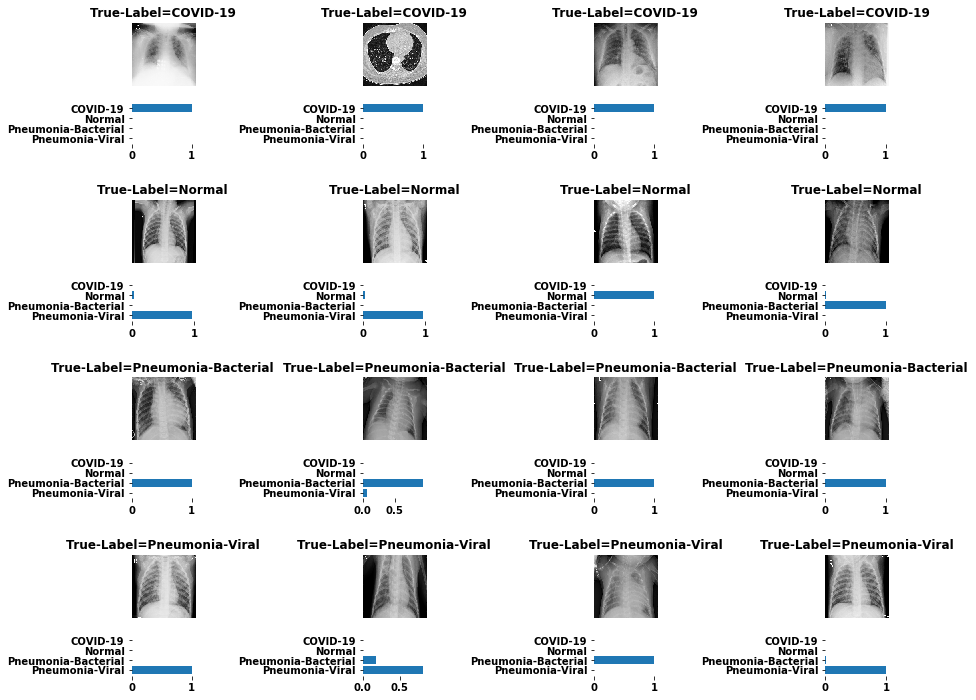

In [43]:
# Plot: using the utility funcs.
class_readable_labels = list(label_images)
top4_labels, top4_probs = process_predictions(predictions, class_readable_labels)

display_predicitons(images= img_batch, 
                    topk_labels= top4_labels, 
                    topk_probabilities= top4_probs, 
                    true_labels=original_labels, 
                    set_true_labels=True)

### Observation:

Upon manual inspection, the model was able to successfully predict patients with COVID-19, however the remainder of the classes, the accuracy/precision decreases. For example, it manages to confuse a lot of the patients that are actually not sick  (NORMAL) to have either bacterial or viral pneumonia. 

This means, that further tuning of the model will be required. __See Notebook (2)__.

### 8.1.3 - Evaluation:

In [44]:
# Import the required Library:
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score)

In [45]:
def eval_model(label_names_mapping, original_labels, predictions):
    """ This function will print out the model's evaluation results.
    Parameters:
        - label_names_mapping, is the Dict of the label mappings (e.g {0: 'COVID-19', 1: 'Normal'})
        - original_labels, is the Numpy array of Labels from the testing data's driectory folder.
        - predictions, are the output predictions from the model (e.g. ResNet's output.)
    Returns:
        - prints out all of the evaluation metrics: accuracy score, model_confusion_matrix, model_classification_report
    """
    # Re-map the Predictions from values to String:
    prediction_results= []
    for i in predictions:
        prediction_results.append( label_names_mapping[ (np.argmax(i)) ] )
        
    # Print out the Classification Reports:
    model_classification_report = classification_report(original_labels, prediction_results)
    print(model_classification_report)
    print(" ")
    
    # Print out the accuracy_score:
    accuracyScore = accuracy_score(original_labels, prediction_results)
    print("Test Accuracy : {}%".format(accuracyScore * 100))
    print(" ")
    
    # Print out the confusion_matrix:
    model_confusion_matrix = confusion_matrix(original_labels, prediction_results)
    ax = plt.subplot()
    sns.heatmap(model_confusion_matrix, annot = True, ax = ax)

    ax.set_xlabel('Predicted')
    ax.set_ylabel('Original')
    ax.set_title('Confusion_matrix')
    plt.show()
    print(" ")
    
    return accuracyScore, model_confusion_matrix, model_classification_report

In [49]:
test_gen = ImageDataGenerator(rescale = 1./255)

test_generator = test_gen.flow_from_directory(batch_size = 4,
                                              directory= test_directory, 
                                              shuffle= True, 
                                              target_size=input_shape[:2], 
                                              class_mode= 'categorical')

evaluate = resnet50.evaluate_generator(test_generator, steps = test_generator.n // 4, verbose =1)

print('Accuracy Test : {}%'.format(evaluate[1] * 100))

Found 16 images belonging to 4 classes.
  ...
    to  
  ['...']
4/4 [==============================] - 1s 137ms/step - loss: 2.2947 - acc: 0.7500
Accuracy Test : 75.0%


                     precision    recall  f1-score   support

           COVID-19       1.00      1.00      1.00         4
             Normal       1.00      0.25      0.40         4
Pneumonia-Bacterial       0.67      1.00      0.80         4
    Pneumonia-Viral       0.60      0.75      0.67         4

           accuracy                           0.75        16
          macro avg       0.82      0.75      0.72        16
       weighted avg       0.82      0.75      0.72        16

 
Test Accuracy : 75.0%
 


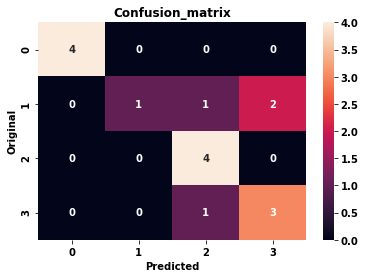

In [47]:
accuracy_score, model_confusion_matrix, model_classification_report = eval_model(label_names_mapping, 
                                                                                 original_labels, 
                                                                                 predictions)

In [48]:
label_names_mapping

{0: 'COVID-19', 1: 'Normal', 2: 'Pneumonia-Bacterial', 3: 'Pneumonia-Viral'}

### Observation:

The confusion matrix confirms the findings from the image plots from the section earlier. Here it can be seen that it was able to correctly identify COVID-19 and Bacterial Pneumonia well, but struggles with the Normal and Viral Pneumonia classes, where it miss classifies these often for Bacterial Pneumonia. This also explains the erratic validation loss and accuracy behaviour in the previous plots. 

Overall when tested, the overall accuracy drops to only ~75% (testing set) from 86.91% (validation set). This is not bad for a start but it  can definitely be improved.

These results confirms that further tuning is required.

The methods that will be tested to improve on its classification results are:
1. Increasing the Validation set ( trying out 70/30 split rather than 80/20)
2. Decrease the Learning rate.
3. Address the Imbalance image datasets with Weighted Loss.
4. The ResNet model requires some regularisation (perhaps in the Fully-Connected Layers)4. The ResNet model's Fully-Connected layers may need to be altered to have deeper layers or less nodes.


MOVE TO NOTEBOOK (2).